# Part 3
## Learning weights (2-qubit example)
From part 2 we have an algorithm that serves as a classifier for given inputs and weights now it's time to actually learn the proper weights for a data set.
<br><br>
Inspired by work by Francesco Tacchino, Chiara Macchiavello, Dario Gerace & Daniele Bajoni https://www.nature.com/articles/s41534-019-0140-4?amp%3Bcode=4cf1b507-7e23-4df0-a2a1-e82a3fe2bc4b

In [77]:
import math
import numpy as np
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit import execute, BasicAer, Aer
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_bloch_multivector

import numpy as np
import matplotlib.pyplot as plt
import random

import import_ipynb
from Part2 import SF_encoder, k2vec, draw_state_vector

## The training procedure
- Start with randomly initialized $\vec{w_0}$
- Loop through the training data, whenever a percetpron outcome is incorrect, adjust the weights
    - If an a training example is classified as positive (activated) when it should have been negative move $\vec{w}$ further from $\vec{i}$ by randomingly flipping a fraction ($l_n$) of the signs where $\vec{w}$ and $\vec{i}$ coincide
    - If an a training example is classified as negative when it should have been should move $\vec{w}$ $\textit{closer}$ to $\vec{i}$ by randomingly flipping a fraction ($l_p$) of the signs where $\vec{w}$ and $\vec{i}$ $\textit{differ}$
- Repeat until all training data is correctly classified

## Generate training set
2 qubits can encode a 4-dimensional classical vector. Since we considering binary vectors, there are $2^{2^2}=16$ possible vectors that will use as our training set. We now just need to generate labels.
<br><br>
Some visualization code

In [2]:
binary_labels = [("{:0%db}"%4).format(i) for i in range(16)]
#print(binary_labels)

binary_matrices = []
for b in binary_labels:
    mat = np.array([[int(b[0]), int(b[1])], [int(b[2]), int(b[3])]])
    binary_matrices.append(mat)

binary_matrices.reverse() # reverse to match with presentation in paper

### Generate labels
Let's say we want to learn the pattern corresponding to $k_i = 1$ or $\vec{i} = [1,1,1,-1]$ as depicted below.

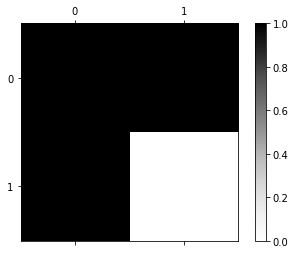

In [3]:
labels = -np.ones(16)
labels[1] = 1

# visualize k_i=1 
fig, ax = plt.subplots()
ax.matshow(binary_matrices[1])
out_plot = ax.imshow(binary_matrices[1], cmap='Greys', interpolation='none')
fig.colorbar(out_plot, ax=ax)

Note that due to global phase, the negative of the pattern is treated as the same. So $k_i=14$ or $\vec{i} = [-1,-1,-1,1]$ will also be given a positive label.

lables: [-1.  1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1. -1.  1. -1.]


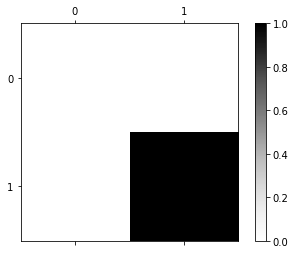

In [11]:
labels[14] = 1
print("lables:", labels)

# visualize k_i=14
fig, ax = plt.subplots()
ax.matshow(binary_matrices[14])
out_plot = ax.imshow(binary_matrices[14], cmap='Greys', interpolation='none')
fig.colorbar(out_plot, ax=ax)

In [71]:
# function to construct a quantum circuit for a given input and weight
def i_w_circuit(i, w):
    q = QuantumRegister(3, 'q')
    c = ClassicalRegister(1, 'c')
    circ = QuantumCircuit(q, c)
    
    # superposition
    circ.h(q[0])
    circ.h(q[1])
    # encode i
    circ += SF_encoder(i)
    # encode w
    circ += SF_encoder(w)
    # rotation
    circ.h(q[0])
    circ.h(q[1])
    circ.x(q[0])
    circ.x(q[1])
    # measure
    circ.ccx(q[0], q[1], q[2])
    circ.measure(q[2],c[0])
    
    #print(circ)
    simulator = Aer.get_backend('qasm_simulator')
    result = execute(circ, simulator, shots=1024).result()
    counts = result.get_counts(circ)

    return counts

# Now to do training algorithm
def train(labels, threshold=0.5, lp=0.5, ln=0.5, max_iter=50):
    # Initialize a random w
    w = np.array(random.choices([-1,1], k=4))
    print("starting w:", w)

    epochs = 1
    while True:
        m = 0
        for k_i in range(16):
            i = k2vec(k_i)
            
            # Get the average of the results of running the circuit
            counts = i_w_circuit(i,w)
            if len(counts) == 1:
                avg_counts = int([*counts][0]) # unpacking
            else:
                avg_counts = counts['1']/float(1024)

            # Apply threshold
            if avg_counts >= threshold:
                output = 1
            else:
                output = -1

            # Check for misclassification
            if np.sign(output) != np.sign(labels[k_i]):
                m += 1
                # case when classified positive (activated) but should be negative
                if np.sign(output) > 0:
                    same_idx = [i for i, z in enumerate(zip(i,w)) if z[0] == z[1]]
                    # randomly select elements to switch signs
                    if len(same_idx) > len(w)*ln:
                        random.shuffle(same_idx)
                        same_idx = same_idx[:int(len(w)*ln)]
                    # change signs of w
                    w[same_idx] *= -1

                # case when classified negative but should be positive
                else:
                    diff_idx = [i for i, z in enumerate(zip(i,w)) if z[0] != z[1]]
                    # randomly select elements to switch signs
                    if len(diff_idx) > len(w)*lp:
                        random.shuffle(diff_idx)
                        diff_idx = diff_idx[:int(len(w)*lp)]
                    # change signs of w
                    w[diff_idx] *= -1
                print("w:", w)
            
        if m == 0:
            print("converged in {} epochs".format(epochs))
            print("w:", w)
            break
        elif epochs == max_iter:
            print("Not converging")
            print("w:", w)
            break
        else:
            epochs += 1
    
    return w

In [72]:
weights = train(labels)

starting w: [ 1 -1 -1 -1]
w: [ 1  1  1 -1]
converged in 2 epochs
w: [ 1  1  1 -1]


## Et Voila! 
Our training function learns the weights the exactly correspond to our target pattern (or it's negative).

[ 1  1  1 -1]


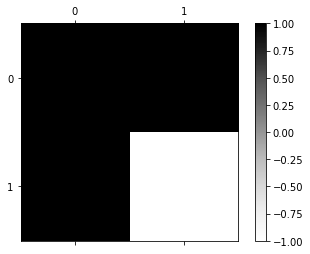

In [76]:
print(weights)
weights_mat = weights.reshape(2,2)

# visualize weights
fig, ax = plt.subplots()
ax.matshow(weights_mat)
out_plot = ax.imshow(weights_mat, cmap='Greys', interpolation='none')
fig.colorbar(out_plot, ax=ax)